In [1]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import get_file
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)
from xgboost import XGBClassifier

In [2]:
# --- 1. Load Data (Same as notebook) ---
print("Loading KDD Cup '99 10% dataset...")
try:
    path = get_file(
        'kddcup.data_10_percent.gz',
        origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz'
    )
except Exception as e:
    print(f'Error downloading data: {e}')
    raise

df = pd.read_csv(path, header=None)
print(f"Original data loaded: {df.shape[0]} rows")

Loading KDD Cup '99 10% dataset...
Original data loaded: 494021 rows


In [3]:
# --- 2. Initial Preprocessing (Same as notebook) ---

# Assign column names
df.columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root',
    'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
    'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'outcome'
]

# Clean data
duplicates_before = df.duplicated().sum()
df.drop_duplicates(keep='first', inplace=True)
print(f"Dropped {duplicates_before} duplicate rows.")

df.dropna(inplace=True, axis=0)
print(f"Cleaned data has {len(df)} rows.")

Dropped 348435 duplicate rows.
Cleaned data has 145586 rows.


In [4]:
# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()
    if sd is None:
        sd = df[name].std()
    
    # Avoid division by zero if std is 0
    if sd == 0:
        df[name] = 0
    else:
        df[name] = (df[name] - mean) / sd

# Encode text values to dummy variables
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [5]:
# --- 4. Apply Encoding (Same as notebook) ---
print("Applying Z-score and One-Hot Encoding...")
# Numeric features
encode_numeric_zscore(df, 'duration')
encode_numeric_zscore(df, 'src_bytes')
encode_numeric_zscore(df, 'dst_bytes')
encode_numeric_zscore(df, 'wrong_fragment')
encode_numeric_zscore(df, 'urgent')
encode_numeric_zscore(df, 'hot')
encode_numeric_zscore(df, 'num_failed_logins')
encode_numeric_zscore(df, 'num_compromised')
encode_numeric_zscore(df, 'root_shell')
encode_numeric_zscore(df, 'su_attempted')
encode_numeric_zscore(df, 'num_root')
encode_numeric_zscore(df, 'num_file_creations')
encode_numeric_zscore(df, 'num_shells')
encode_numeric_zscore(df, 'num_access_files')
encode_numeric_zscore(df, 'num_outbound_cmds')
encode_numeric_zscore(df, 'count')
encode_numeric_zscore(df, 'srv_count')
encode_numeric_zscore(df, 'serror_rate')
encode_numeric_zscore(df, 'srv_serror_rate')
encode_numeric_zscore(df, 'rerror_rate')
encode_numeric_zscore(df, 'srv_rerror_rate')
encode_numeric_zscore(df, 'same_srv_rate')
encode_numeric_zscore(df, 'diff_srv_rate')
encode_numeric_zscore(df, 'srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_count')
encode_numeric_zscore(df, 'dst_host_srv_count')
encode_numeric_zscore(df, 'dst_host_same_srv_rate')
encode_numeric_zscore(df, 'dst_host_diff_srv_rate')
encode_numeric_zscore(df, 'dst_host_same_src_port_rate')
encode_numeric_zscore(df, 'dst_host_srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_serror_rate')
encode_numeric_zscore(df, 'dst_host_srv_serror_rate')
encode_numeric_zscore(df, 'dst_host_rerror_rate')
encode_numeric_zscore(df, 'dst_host_srv_rerror_rate')

# Categorical features
encode_text_dummy(df, 'protocol_type')
encode_text_dummy(df, 'service')
encode_text_dummy(df, 'flag')
encode_text_dummy(df, 'land')
encode_text_dummy(df, 'logged_in')
encode_text_dummy(df, 'is_host_login')
encode_text_dummy(df, 'is_guest_login')

# Drop columns with NaNs created by Z-score (e.g., if std=0)
df.dropna(inplace=True, axis=1)
print(f"Data shape after encoding: {df.shape}")

Applying Z-score and One-Hot Encoding...


C:\Users\rahul\AppData\Local\Temp\ipykernel_21668\1873436567.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]
C:\Users\rahul\AppData\Local\Temp\ipykernel_21668\1873436567.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]
C:\Users\rahul\AppData\Local\Temp\ipykernel_21668\1873436567.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at onc

Data shape after encoding: (145586, 122)


In [6]:
# --- 5. Prepare X and y for XGBoost ---
x_columns = df.columns.drop('outcome')
x = df[x_columns].values
x = x.astype('float32')

# For XGBoost, we need 1D integer labels, not one-hot encoding
le = LabelEncoder()
y = le.fit_transform(df['outcome'])
outcomes = le.classes_
num_classes = len(outcomes)

print(f"x shape: {x.shape}, dtype: {x.dtype}")
print(f"y shape: {y.shape}, dtype: {y.dtype}")
print(f"Number of classes: {num_classes}")

x shape: (145586, 121), dtype: float32
y shape: (145586,), dtype: int64
Number of classes: 23


In [7]:
# --- 6. Train-Test Split (Same as notebook, with stratification) ---
# [Image of stratified sampling vs random sampling]
print("Splitting data using stratification...")
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.40, random_state=42, stratify=y  # <-- THIS IS THE FIX
)
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

# Verify that all classes are in the test set
test_class_counts = np.unique(y_test, return_counts=True)
print(f"Classes present in test set: {len(test_class_counts[0])} (should be {num_classes})")

Splitting data using stratification...
x_train shape: (87351, 121), y_train shape: (87351,)
x_test shape: (58235, 121), y_test shape: (58235,)
Classes present in test set: 23 (should be 23)


In [8]:
# --- 7. Define and Train XGBoost Model ---
model = XGBClassifier(
    objective='multi:softmax',  # Multi-class classification
    num_class=num_classes,      # Number of classes
    n_estimators=200,           # Number of trees
    learning_rate=0.1,
    max_depth=5,
    early_stopping_rounds=10,   # Similar to Keras EarlyStopping
    n_jobs=-1,                  # Use all available cores
    random_state=42
)

print("\nTraining XGBoost model...")
start_time = dt.datetime.now()
model.fit(
    x_train, 
    y_train,
    eval_set=[(x_test, y_test)],
    verbose=True
)
end_time = dt.datetime.now()
print(f"Training completed in: {end_time - start_time}")


Training XGBoost model...
[0]	validation_0-mlogloss:1.98631
[1]	validation_0-mlogloss:1.64483
[2]	validation_0-mlogloss:1.40637
[3]	validation_0-mlogloss:1.22348
[4]	validation_0-mlogloss:1.07487
[5]	validation_0-mlogloss:0.95163
[6]	validation_0-mlogloss:0.84694
[7]	validation_0-mlogloss:0.75639
[8]	validation_0-mlogloss:0.67775
[9]	validation_0-mlogloss:0.60856
[10]	validation_0-mlogloss:0.54708
[11]	validation_0-mlogloss:0.49290
[12]	validation_0-mlogloss:0.44440
[13]	validation_0-mlogloss:0.40097
[14]	validation_0-mlogloss:0.36215
[15]	validation_0-mlogloss:0.32737
[16]	validation_0-mlogloss:0.29615
[17]	validation_0-mlogloss:0.26808
[18]	validation_0-mlogloss:0.24283
[19]	validation_0-mlogloss:0.22008
[20]	validation_0-mlogloss:0.19955
[21]	validation_0-mlogloss:0.18104
[22]	validation_0-mlogloss:0.16430
[23]	validation_0-mlogloss:0.14918
[24]	validation_0-mlogloss:0.13554
[25]	validation_0-mlogloss:0.12321
[26]	validation_0-mlogloss:0.11208
[27]	validation_0-mlogloss:0.10193
[28

In [9]:
# --- 8. Define Evaluation Functions (Similar to notebook) ---

def confusion_matrix_func(y_true, y_pred, labels):
    """
    Plots a confusion matrix heatmap.
    """
    C = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(C, index=labels, columns=labels)
    
    plt.figure(figsize=(20, 15))
    sns.set(font_scale=1.0)  # Adjusted font scale for better fit
    sns.heatmap(
        cm_df, 
        annot=True, 
        annot_kws={"size": 10}, 
        fmt='g'
    )
    plt.title('XGBoost Confusion Matrix (Stratified Split)')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout() # Add tight layout to prevent label cutoff
    plt.show()


Predicting on the test data:
Completed
Time taken: 0:00:01.271615
Validation score (Accuracy): 0.9992100970206921
Recall score (Weighted): 0.9992100970206921
Precision score (Weighted): 0.9991354128651538
F1 score (Weighted): 0.9991447513174857
ROC-AUC score (One-vs-Rest): 0.9999080653096628
Generating confusion matrix plot...


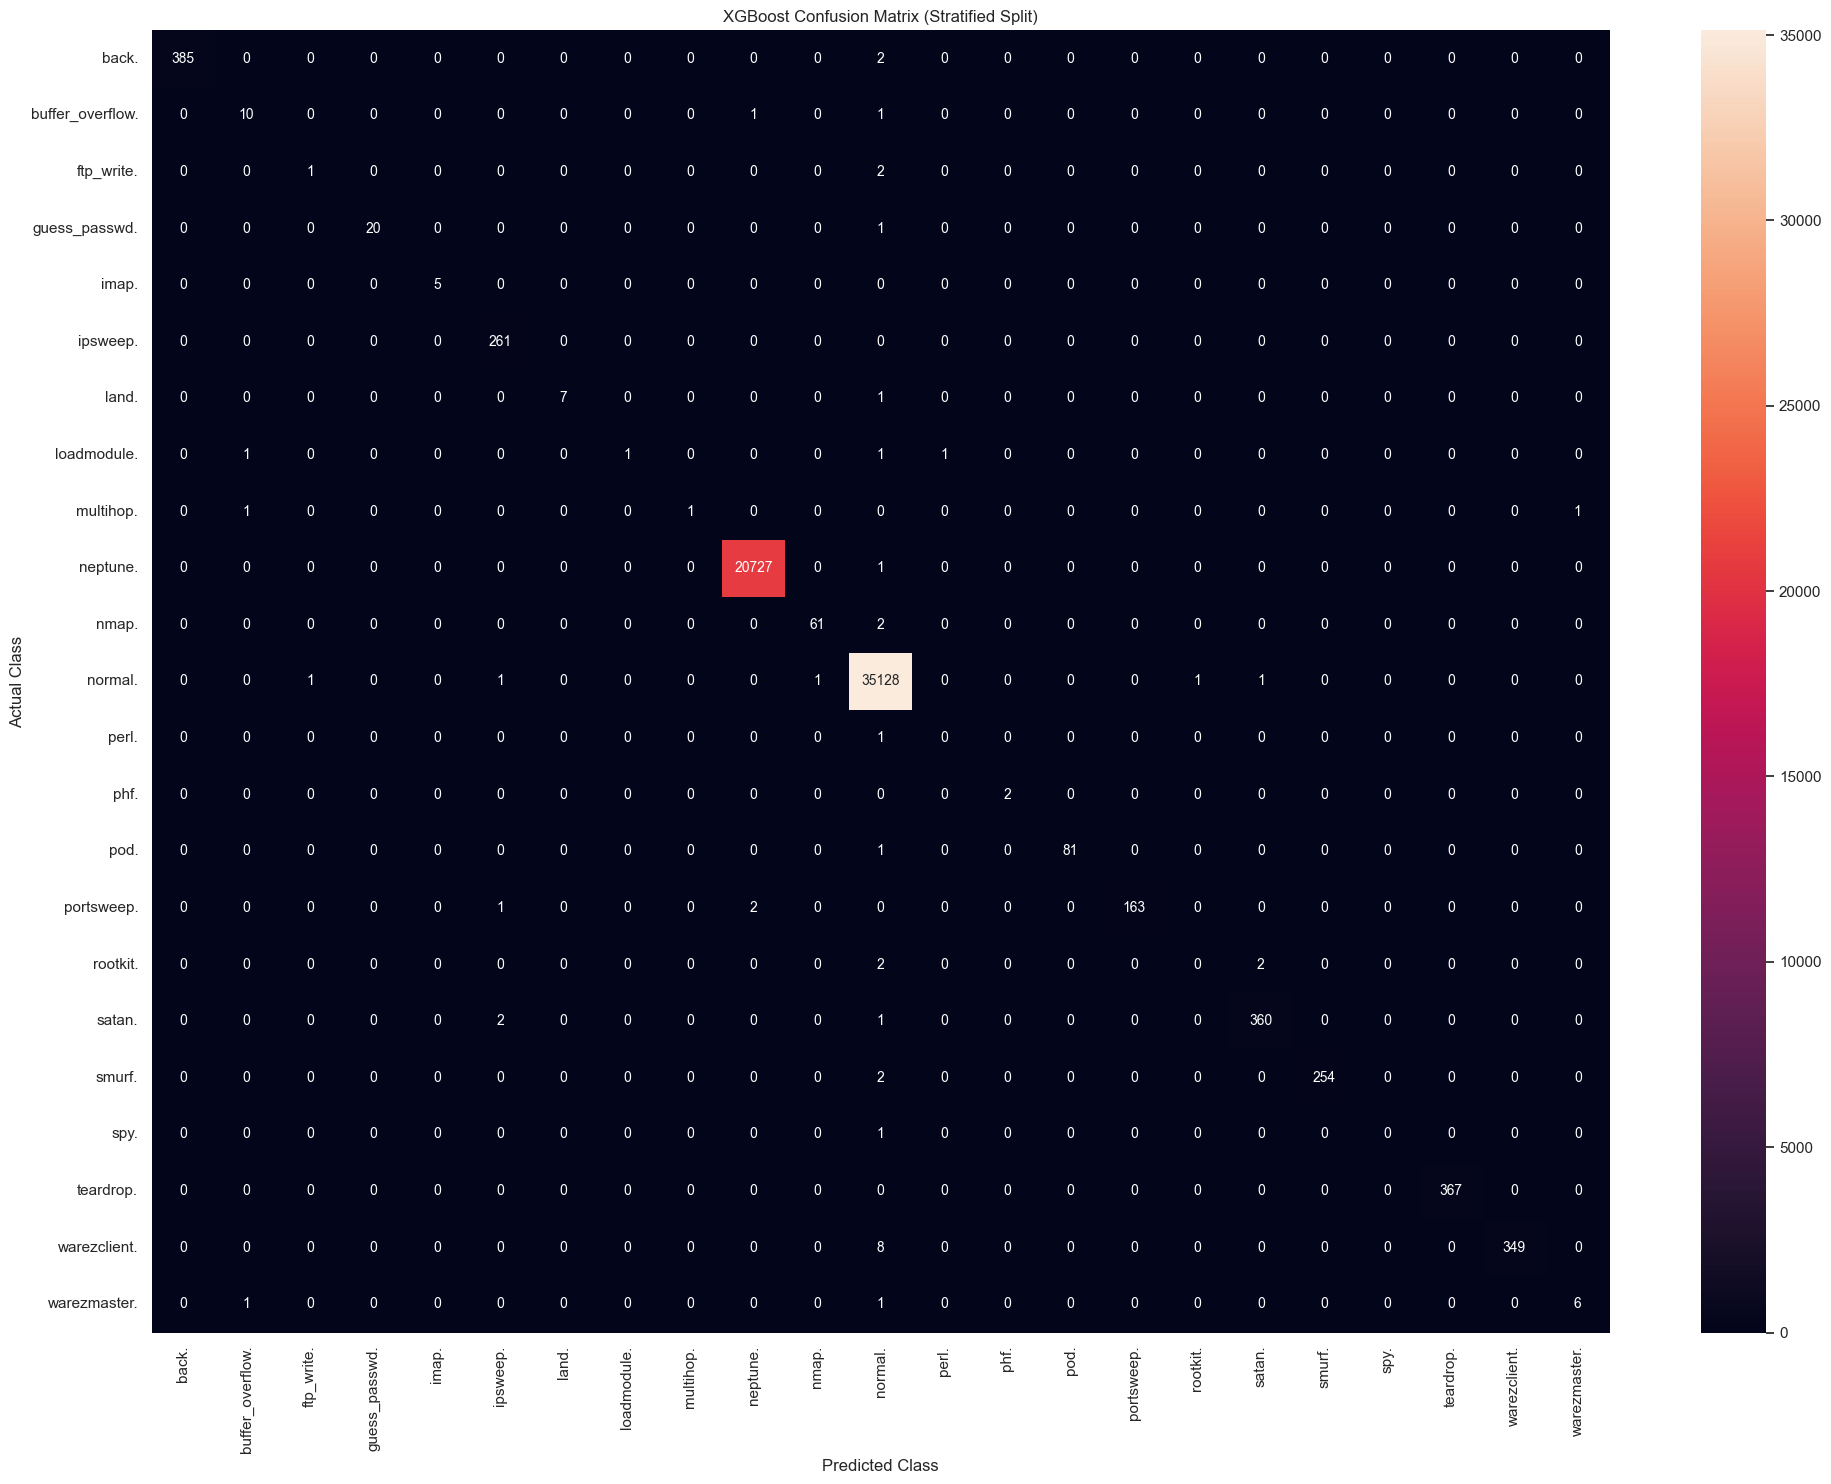

Script finished.


In [10]:
# --- 9. Evaluate Model (Required Outputs) ---
print('\nPredicting on the test data:')
start = dt.datetime.now()

# Get probabilities for ROC-AUC
pred_proba = model.predict_proba(x_test)
# Get class predictions
pred = model.predict(x_test)
y_eval = y_test  # y_test is already 1D labels

# Calculate Metrics
vscore = accuracy_score(y_eval, pred)
rscore = recall_score(y_eval, pred, average='weighted', zero_division=0)
ascore = precision_score(y_eval, pred, average='weighted', zero_division=0)
f1score = f1_score(y_eval, pred, average='weighted', zero_division=0)
# Use 'ovr' (one-vs-rest) for multi-class ROC-AUC
roc_auc = roc_auc_score(y_eval, pred_proba, multi_class='ovr')

end_predict_time = dt.datetime.now() - start
print('Completed')
print(f'Time taken: {end_predict_time}') # User requested format
print('=' * 50)
print(f"Validation score (Accuracy): {vscore}") # User requested format
print('=' * 50)
print(f"Recall score (Weighted): {rscore}") # User requested format
print('=' * 50)
print(f"Precision score (Weighted): {ascore}") # User requested format
print('=' * 50)
print(f"F1 score (Weighted): {f1score}") # User requested format
print('=' * 50)
print(f"ROC-AUC score (One-vs-Rest): {roc_auc}") # User requested format
print('=' * 50)

# Display Confusion Matrix
print("Generating confusion matrix plot...")
confusion_matrix_func(y_eval, pred, outcomes)
print("Script finished.")